## Brain MRI Segmentation with Unet | TensorFlow and Keras

In [16]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import sys
sys.path.insert(0,"/content/drive/MyDrive/DL_colab/DL_AAT")

In [18]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from keras import Input
from keras.models import Model, load_model, save_model
from keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint

from utils import *
from unet import *

In [19]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [20]:
# Setting size parameters of images
im_width = 256
im_height = 256

## Loading the image and mask paths

In [21]:
sys.path[0]+"/kaggle_3m"

'/content/drive/MyDrive/DL_colab/DL_AAT/kaggle_3m'

In [22]:
image_filenames_train = []

# creating a list of all files containing the word 'mask'
# in Local Machine
# mask_files = glob('../../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

# in Kaggle
mask_files = glob(sys.path[0]+'/kaggle_3m/*/*_mask*')

for i in mask_files:
    image_filenames_train.append(i.replace('_mask', ''))

print(image_filenames_train[:10])
len(image_filenames_train)




['/content/drive/MyDrive/DL_colab/DL_AAT/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_17.tif', '/content/drive/MyDrive/DL_colab/DL_AAT/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_13.tif', '/content/drive/MyDrive/DL_colab/DL_AAT/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_2.tif', '/content/drive/MyDrive/DL_colab/DL_AAT/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_3.tif', '/content/drive/MyDrive/DL_colab/DL_AAT/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_18.tif', '/content/drive/MyDrive/DL_colab/DL_AAT/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_5.tif', '/content/drive/MyDrive/DL_colab/DL_AAT/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_15.tif', '/content/drive/MyDrive/DL_colab/DL_AAT/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_19.tif', '/content/drive/MyDrive/DL_colab/DL_AAT/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif', '/content/drive/MyDrive/DL_colab/DL_AAT/kaggle_3m/TCGA_CS_5395_19981004/TCGA

3929

## Plotting few images and masks

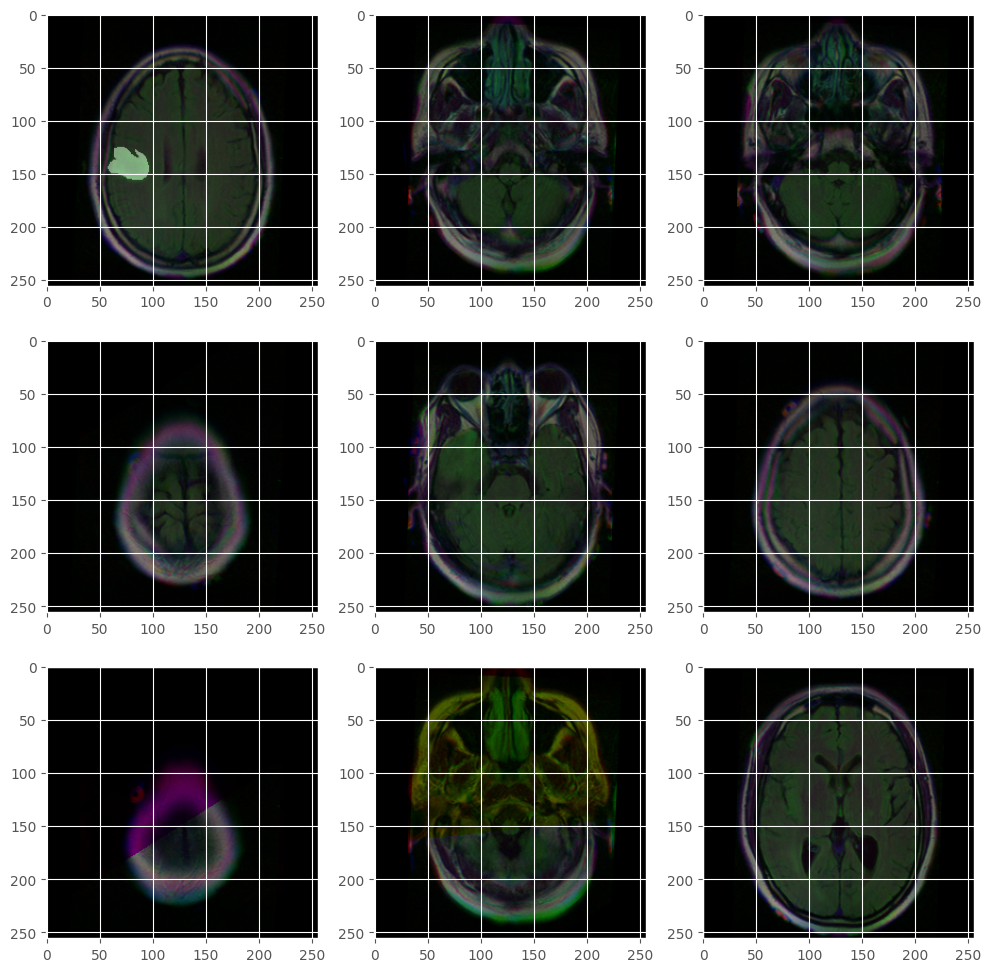

In [23]:
plot_from_img_path(3, 3 , image_filenames_train, mask_files )

# **Create data frame and split data on train set, validation set and test set**

In [24]:
df = pd.DataFrame(data={'image_filenames_train': image_filenames_train, 'mask': mask_files })

df_train, df_test = train_test_split(df, test_size=0.1)

# Further split this val and train
df_train, df_val = train_test_split(df_train, test_size=0.2)

print(df_train.shape)
print(df_test.shape)
print(df_val.shape)


(2828, 2)
(393, 2)
(708, 2)


## **Data genertator, data augmentation and adjust data**

In [25]:
''' After mask Normalization if the value is <= 0.5 then that Mask 
will be considered a complete black one and does not have any Tumor '''
def normalize_and_diagnose(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return(img, mask)

In [26]:
# Referring Code From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=(256, 256),
    seed=1,
):
    """
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    """
    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image_filenames_train",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )

    train_gen = zip(image_generator, mask_generator)
    
    # Final return Tuple after image Normalization and Diagnostics
    for (img, mask) in train_gen:
        img, mask = normalize_and_diagnose(img, mask)
        yield (img, mask)

In [27]:
EPOCHS = 20
BATCH_SIZE = 32
learning_rate = 1e-4
smooth=100

In [28]:
model = unet()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_57 (Conv2D)             (None, 256, 256, 64  1792        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 activation_54 (Activation)     (None, 256, 256, 64  0           ['conv2d_57[0][0]']              
                                )                                                           

In [29]:
train_generator_param = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_param,
                                target_size=(im_height, im_width))
    
test_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
    
model = unet(input_size=(im_height, im_width, 3))



decay_rate = learning_rate / EPOCHS

opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)

model.compile(optimizer=opt, loss=dice_coefficients_loss, metrics=["binary_accuracy", iou, dice_coefficients])

callbacks = [ModelCheckpoint('unet.hdf5', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gen,
                    validation_steps=len(df_val) / BATCH_SIZE)

Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/20
89/88 [==============================] - ETA: -2s - loss: -0.0917 - binary_accuracy: 0.8770 - iou: 0.0490 - dice_coefficients: 0.0922Found 708 validated image filenames.
Found 708 validated image filenames.

Epoch 1: val_loss improved from inf to -0.02401, saving model to unet.hdf5
88/88 [==============================] - 569s 6s/step - loss: -0.0917 - binary_accuracy: 0.8770 - iou: 0.0490 - dice_coefficients: 0.0922 - val_loss: -0.0240 - val_binary_accuracy: 0.9905 - val_iou: 0.0120 - val_dice_coefficients: 0.0235
Epoch 2/20
89/88 [==============================] - ETA: 0s - loss: -0.1583 - binary_accuracy: 0.9789 - iou: 0.0869 - dice_coefficients: 0.1583
Epoch 2: val_loss improved from -0.02401 to -0.05626, saving model to unet.hdf5
88/88 [==============================] - 152s 2s/step - loss: -0.1583 - binary_accuracy: 0.9789 - iou: 0.0869 - dice_coefficients: 0.1583 - val_loss: -0.0563 - val_bina

In [32]:
history_post_training = pd.DataFrame(history.history)
history_post_training

,loss,binary_accuracy,iou,dice_coefficients,val_loss,val_binary_accuracy,val_iou,val_dice_coefficients
0,-0.091680,0.876971,0.048975,0.092232,-0.024014,0.990547,0.011993,0.023525
1,-0.158331,0.978928,0.086871,0.158325,-0.056262,0.962578,0.029697,0.057289
2,-0.196558,0.985433,0.110163,0.196047,-0.070183,0.991972,0.036972,0.070378
3,-0.236876,0.988617,0.135885,0.235531,-0.094381,0.992466,0.048736,0.091064
4,-0.280713,0.990544,0.165854,0.280989,-0.191780,0.983533,0.114361,0.200589
5,-0.335645,0.992574,0.205254,0.336636,-0.313035,0.994178,0.187666,0.311206
6,-0.390583,0.993523,0.246531,0.390274,-0.380201,0.995158,0.242405,0.386184
7,-0.449486,0.994709,0.295605,0.450667,-0.433875,0.991453,0.287863,0.439494
8,-0.500748,0.994733,0.338030,0.499524,-0.510842,0.994148,0.340181,0.502875
9,-0.547630,0.995343,0.381752,0.546193,-0.578431,0.996692,0.424359,0.587579


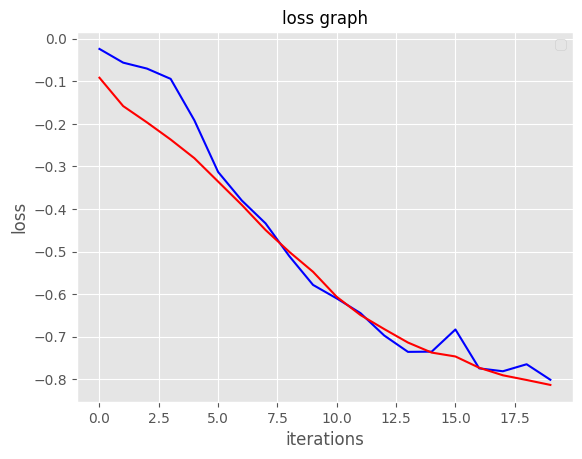

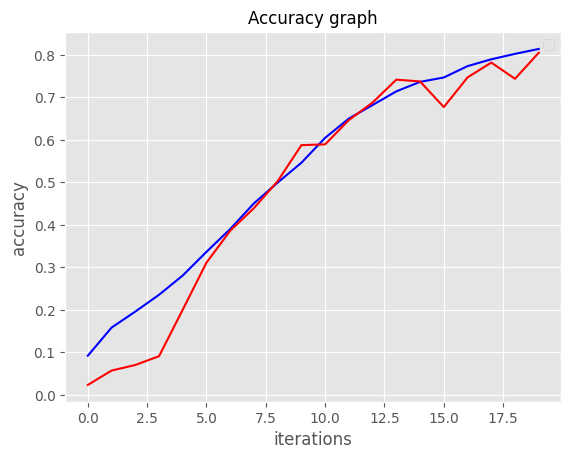

In [35]:
# history_post_training = history.history

train_dice_coeff_list = history_post_training['dice_coefficients']
test_dice_coeff_list = history_post_training['val_dice_coefficients']

train_jaccard_list = history_post_training['iou']
test_jaccard_list = history_post_training['val_iou']

train_loss_list = history_post_training['loss']
test_loss_list = history_post_training['val_loss']

plt.figure(1)
plt.plot(test_loss_list, 'b-')
plt.plot(train_loss_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('loss graph', fontsize=12)
plt.legend()

plt.figure(2)
plt.plot(train_dice_coeff_list, 'b-')
plt.plot(test_dice_coeff_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.title('Accuracy graph', fontsize=12)
plt.legend()
plt.show()

## Load previously trained Model

In [41]:
# model = load_model('unet.hdf5', custom_objects={'dice_coefficient_loss': dice_coefficients_loss, 'iou': iou, 'dice_coefficient': dice_coefficients  } )
model = load_model('unet.hdf5', custom_objects={'dice_coefficients_loss': dice_coefficients_loss, 'iou': iou, 'dice_coefficients': dice_coefficients  } )

In [42]:
test_gen = train_generator(df_test, BATCH_SIZE, dict(), target_size=(im_height, im_width)  )

results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE )

print('Test Loss ', results[0] )
print('Test IoU ', results[1] )
print('Test Dice Coefficient ', results[2] )


Found 393 validated image filenames.
Found 393 validated image filenames.
12/12 [==============================] - 54s 5s/step - loss: -0.8127 - binary_accuracy: 0.9969 - iou: 0.6875 - dice_coefficients: 0.8133
Test Loss  -0.8127030730247498
Test IoU  0.996879518032074
Test Dice Coefficient  0.6875194907188416


## Plotting Predicted Masks Segmentation results from the Test Image set

1/1 [==============================] - 3s 3s/step


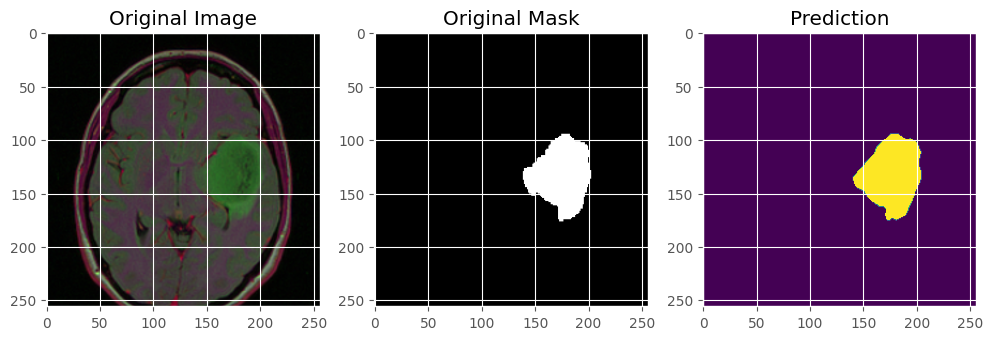

1/1 [==============================] - 0s 38ms/step


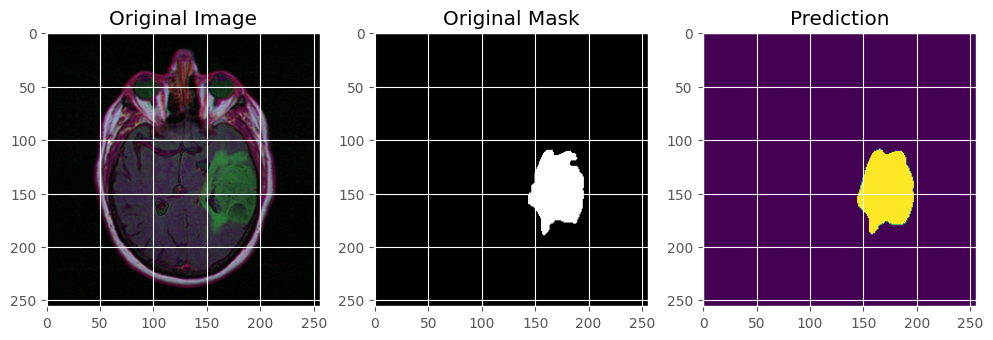

1/1 [==============================] - 0s 20ms/step


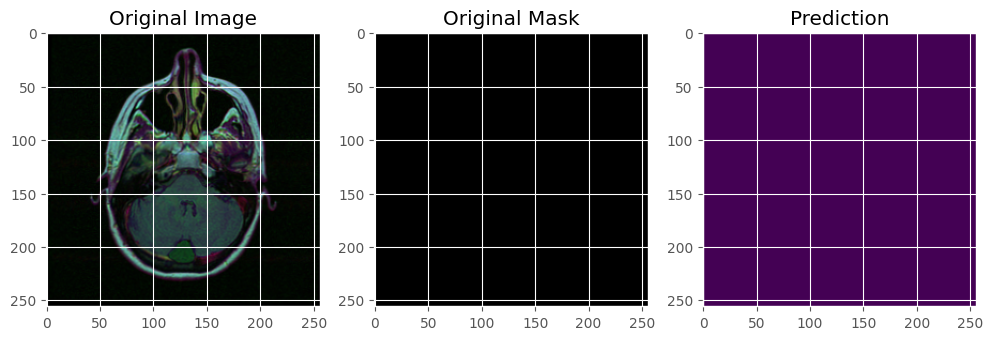

1/1 [==============================] - 0s 20ms/step


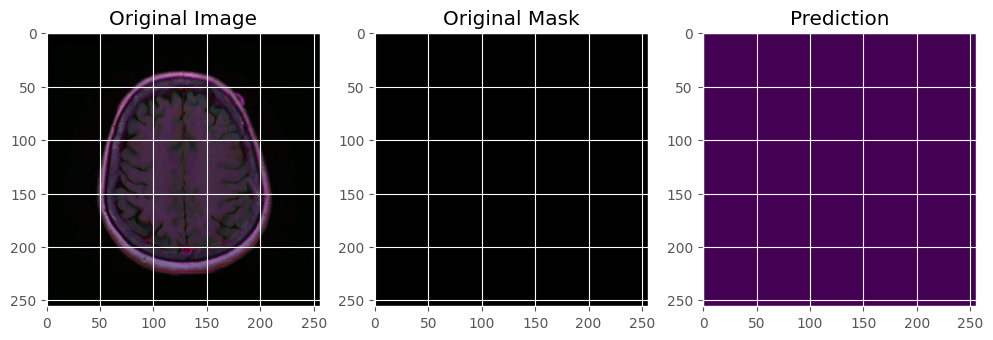

1/1 [==============================] - 0s 21ms/step


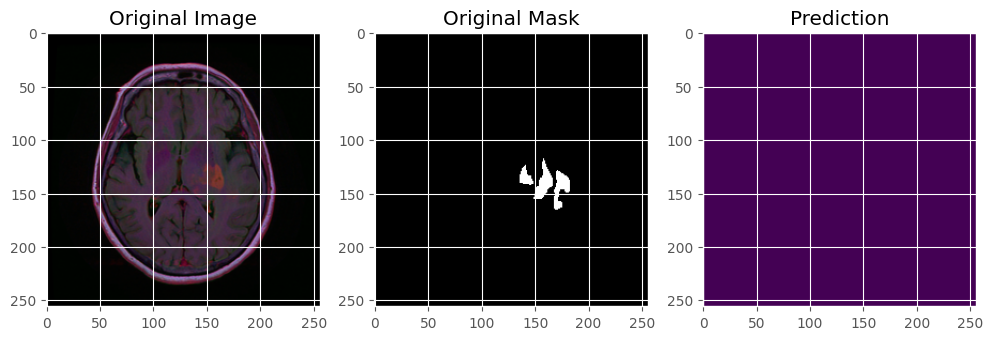

1/1 [==============================] - 0s 20ms/step


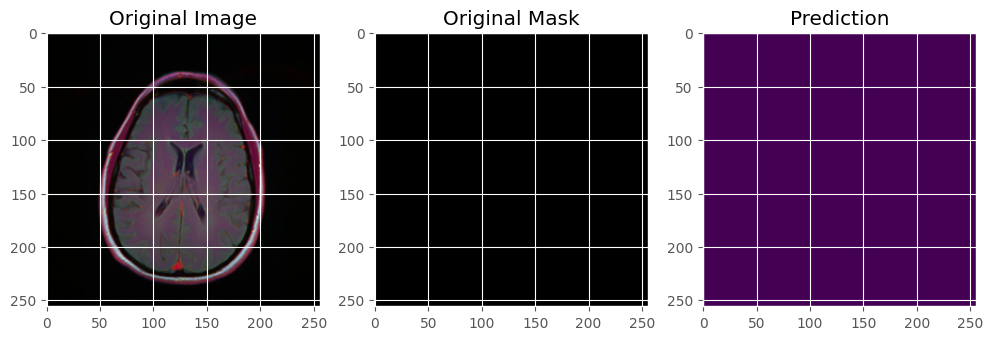

1/1 [==============================] - 0s 22ms/step


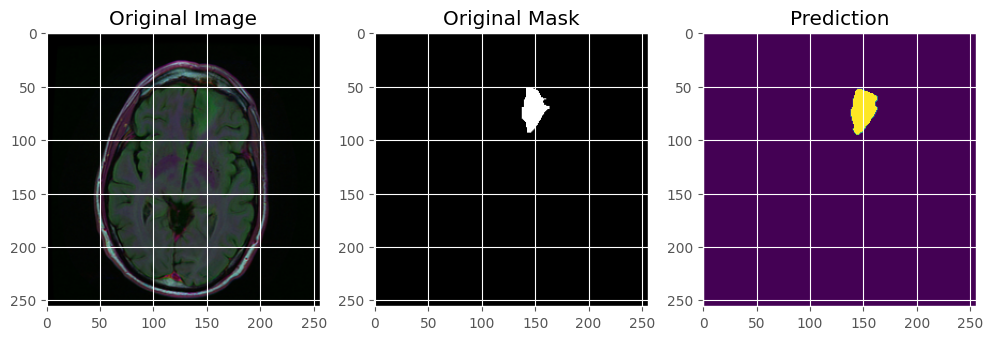

1/1 [==============================] - 0s 19ms/step


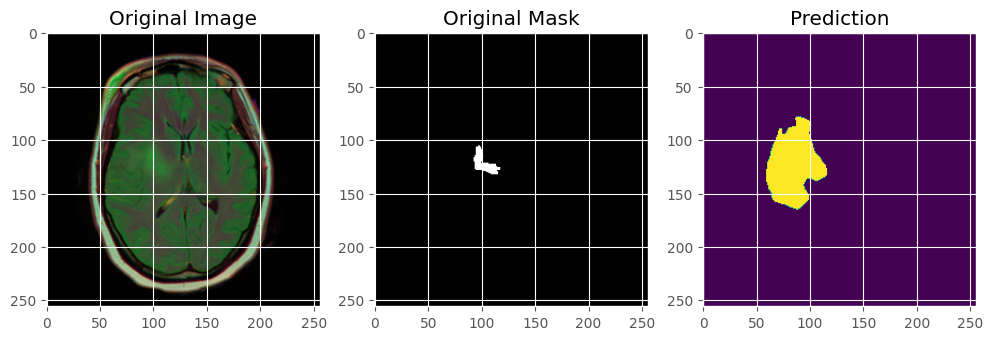

1/1 [==============================] - 0s 26ms/step


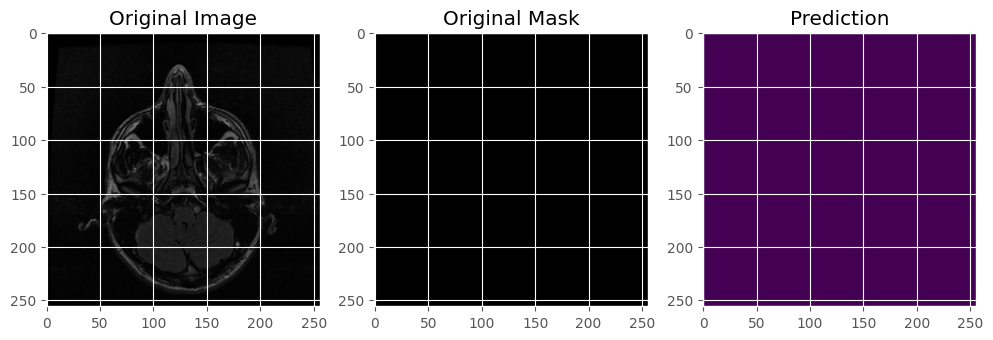

1/1 [==============================] - 0s 21ms/step


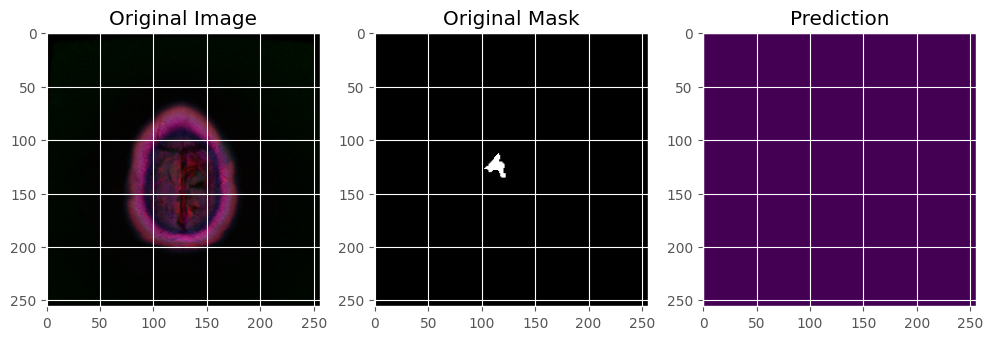

1/1 [==============================] - 0s 26ms/step


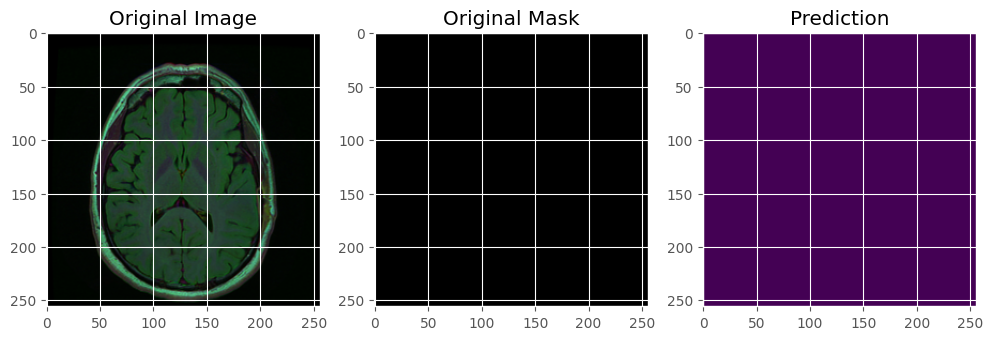

1/1 [==============================] - 0s 21ms/step


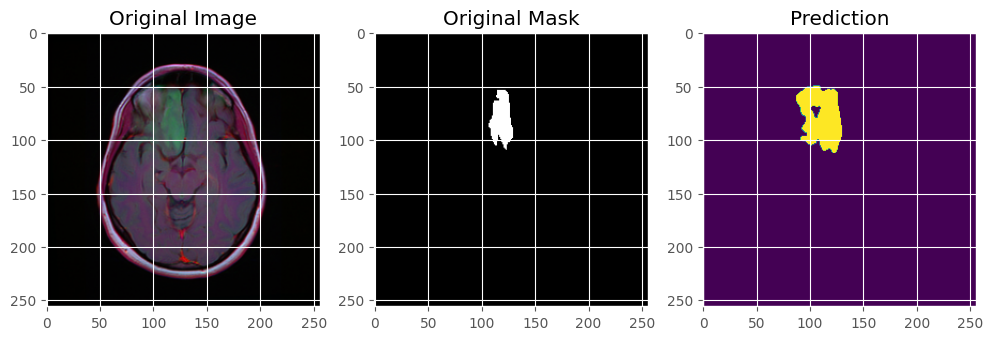

1/1 [==============================] - 0s 22ms/step


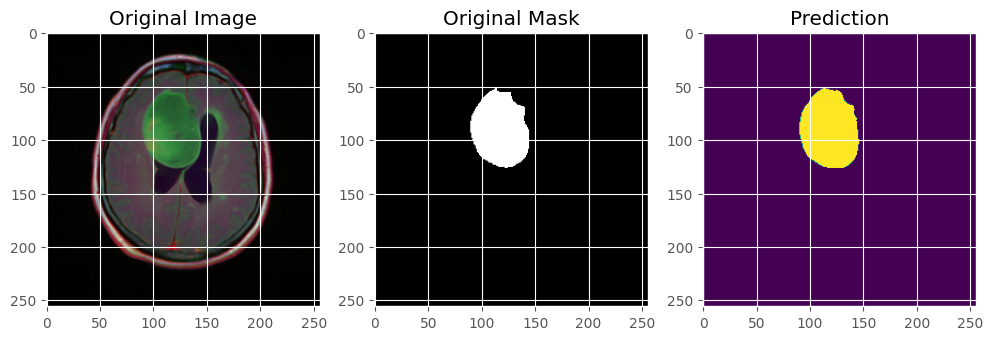

1/1 [==============================] - 0s 20ms/step


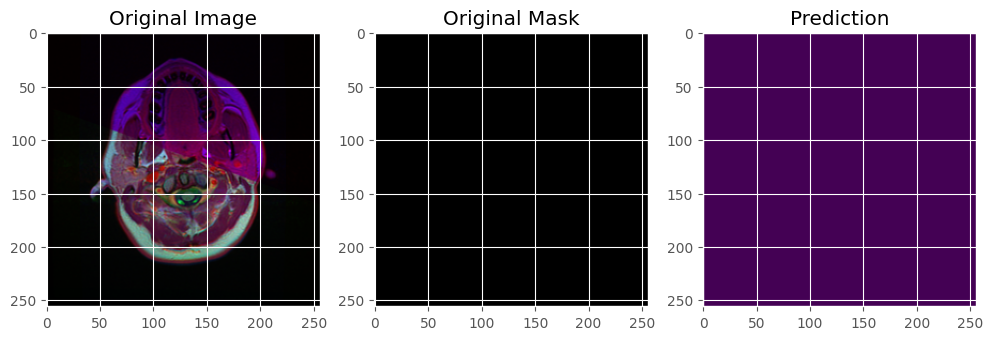

1/1 [==============================] - 0s 21ms/step


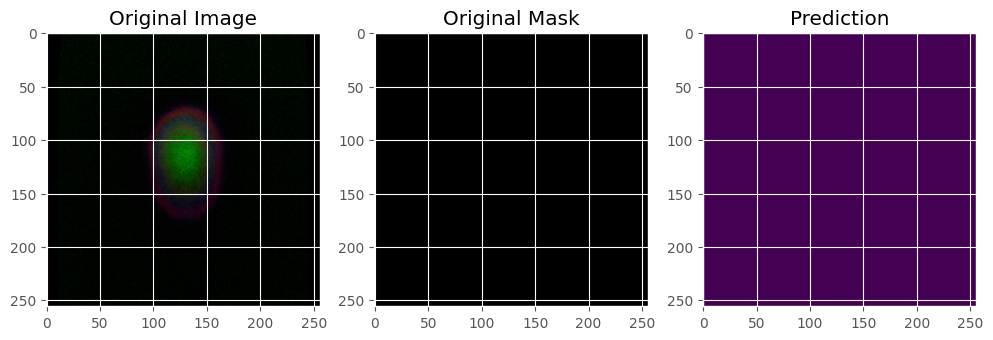

1/1 [==============================] - 0s 23ms/step


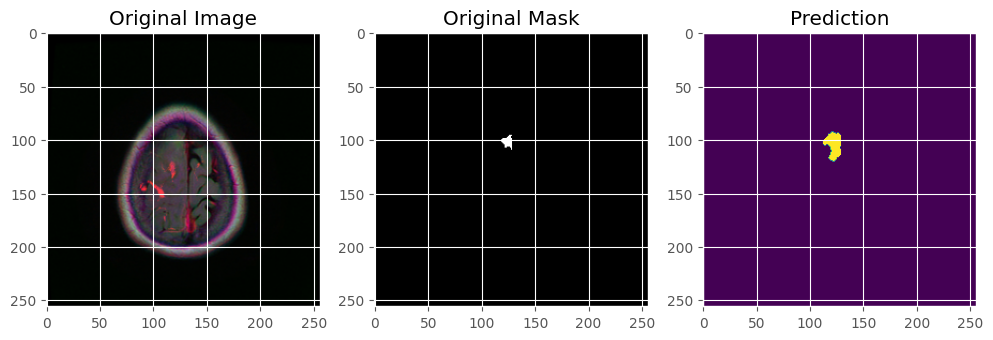

1/1 [==============================] - 0s 24ms/step


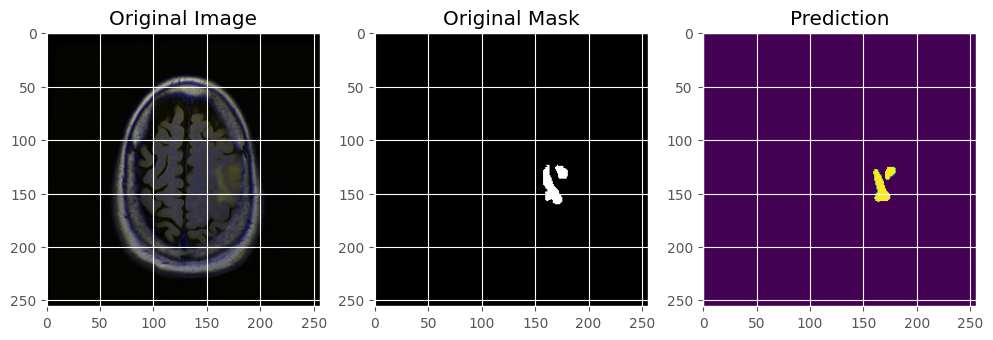

1/1 [==============================] - 0s 20ms/step


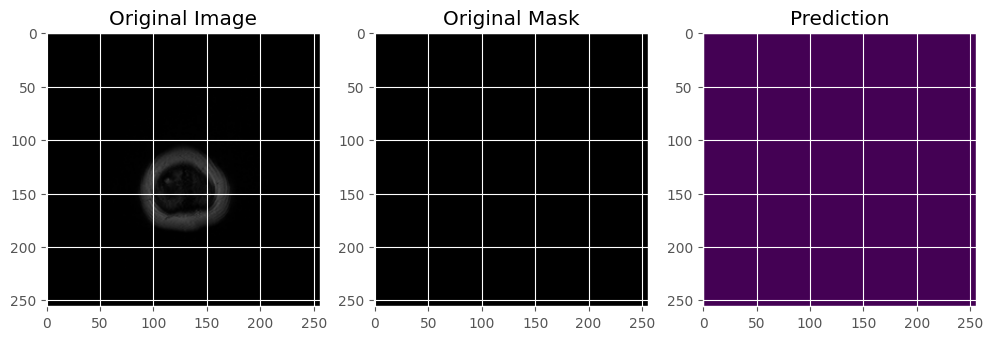

1/1 [==============================] - 0s 28ms/step


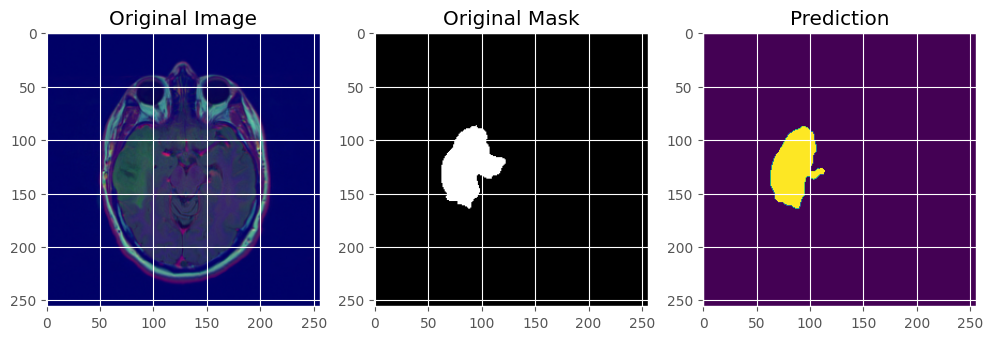

1/1 [==============================] - 0s 28ms/step


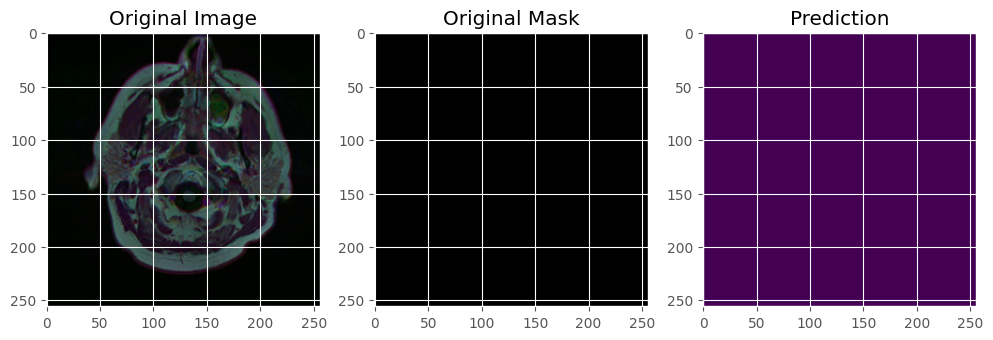

In [44]:
for i in range(20):
    index = np.random.randint(1, len(df_test.index))
    img = cv2.imread(df_test['image_filenames_train'].iloc[index])
    img = cv2.resize(img, (im_height, im_width))
    img = img/255
    # print(imgs.shape) (256, 256 , 3)
    img = img[np.newaxis, :, :, : ]
    # print(img.shape) # (1, 256, 256, 3)

    predicted_img = model.predict(img)
    
    plt.figure(figsize=(12, 12))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5 )
    plt.title('Prediction')
    plt.show()

    